# Weather Analysis by Latitude

## Overview

This notebook visualizes the current weather in 500 unique cities across the world in random locations. [Citipy](https://pypi.python.org/pypi/citipy) a simple city-finding python package will be used to find randomly located cities, and the [OpenWeatherMap API](https://openweathermap.org/api), will return current weather statistics for those cities.

A series of scatter plots will be used to showcase the following relationships:

* Temperature (F) vs. Latitude.
* Humidity (%) vs. Latitude.
* Cloudiness (%) vs. Latitude.
* Wind Speed (mph) vs. Latitude.

Specifically, this script will:

* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
* Perform a weather check on each of the cities using a series of successive API calls. 
* Include a print log of each city as it's being processed with the city number, city name, and requested URL.
* Save both a CSV of all data retrieved and png images for each scatter plot.

In [1]:
# Import dependencies.
from citipy import citipy
import numpy as np
import pandas as pd
import random
import datetime as date
import requests as req
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Import Open Weather Map API keys.
from openWeatherMapApiKeys import apiKey


## Sampling Cities

Finding a city by searching random latitude and longitude values with Citipy can be problematic. Randomly selected remote locations, such as points in the middle of the Pacific Ocean or in Antarctica, may yield a city thousands of miles away in any direction. This is a problem for extremely northern or southern latitudes, or longitudes in the Pacific Ocean: random points in these areas inflate the number of cities selected in extreme northern or southern areas, or around the Pacific Rim.

To solve this, the range of latitudes is restricted to between 55th parallel south (running through Patagonia, Argentina) and 65th parallel north (running through southern Greenland and northern Canada). Longitudes are restricted to between 140th meridian west (which removes most of Alaska from the sample) and 160 meridian east (which leaves points west of Australia out). This yields a more uniform distribution of points that resolve to a city in Citipy, particularly by latitude.

In [2]:
# Declare variables describing the scope of lat/lng search for cities.
latDim = {'min': -55, 'max': 65}
lngDim = {'min': -140, 'max': 180}

# Create arrays containing increments of lat and long.
latVals = np.arange(latDim['min'], latDim['max'], 0.1)
lngVals = np.arange(lngDim['min'], lngDim['max'], 0.1)

In [3]:
# Create an empty data frame that will contain details of our randomly selected cities.
colNames = ('cityName', 'countryCode', 'randLat', 'randLng', 'uniqueName', 'Latitude', 'Longitude','Temperature',
            'Humidity','Cloudiness','WindSpeed')
cities = pd.DataFrame(columns = colNames)

In [4]:
# Query Citipy for random lat long values until we collect our sample, and append weather
# data via API call.

# Set the sample size (this will return exactly as many records as the sample size).
sampleSize = 500

baseUrl = 'http://api.openweathermap.org/data/2.5/weather?q='
units = 'imperial'

# Set the current date and time the data was retrieved, for labeling.
analysistime = date.datetime.now()
analysistimename = analysistime.strftime("%b %d, %Y %I:%M %p")

while len(cities) <= sampleSize:
    # Choose a random point within our lat-lng domain.
    randLat = random.choice(latVals)
    randLng = random.choice(lngVals)
    # Call citipy's nearest_city() method to get a city object.
    city = citipy.nearest_city(randLat, randLng)
    cityName = city.city_name.replace(' ', '%20')
    countryCode = city.country_code
    # Check if the combination of city name and country code from citipy is already present in our data frame
    # This is the best that can be done with the nearest_city() method.
    if cityName + countryCode in cities.uniqueName.tolist():
        pass
    else:
        url = baseUrl + cityName + ',' + countryCode + '&units=' + units + '&APPID=' + apiKey
        weather_response = req.get(url)
        weather_json = weather_response.json()
        print('Status code: %s DF Length is now: %s' % (str(weather_json["cod"]), str(len(cities))))
        if weather_json["cod"] == 200:
            print('City %s: %s loaded with status %s: %s' % (weather_json['id'], weather_json['name'], weather_json["cod"], url))
            Latitude = weather_json["coord"]["lat"]
            Longitude = weather_json["coord"]["lon"]
            Temperature = weather_json["main"]["temp"]
            Humidity = weather_json["main"]["humidity"]
            Cloudiness = weather_json["clouds"]["all"]
            WindSpeed = weather_json["wind"]["speed"]
            cities.loc[len(cities)+1] = [weather_json['name'], countryCode, randLat, randLng, cityName+countryCode, Latitude, Longitude, Temperature, Humidity, Cloudiness, WindSpeed]
#             cities = concat(cities, DataFrame([{'cityName': cityName, 'countryCode' : countryCode, 'randLat' : randLat,'randLng' : randLng, 'uniqueName' : cityName, 'Latitude' : Latitude, 'Longitude' : Longitude,'Temperature' : Temperature, 'Humidity' : Humidity,'Cloudiness' : Cloudiness,'WindSpeed' : WindSpeed}])
        else:
            pass


Status code: 200 DF Length is now: 0
City 3994469: Ojinaga loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=ojinaga,mx&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 1
City 921786: Mitsamiouli loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=mitsamiouli,km&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 2
City 3448903: Sao Joao da Barra loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=sao%20joao%20da%20barra,br&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 3
City 3652764: Puerto Ayora loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=puerto%20ayora,ec&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 4
City 964420: Port Elizabeth loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=port%20elizabeth,za&units=imp

In [5]:
print(cities.head())

            cityName countryCode  randLat  randLng                 uniqueName  \
1            Ojinaga          mx     29.9   -103.3                  ojinagamx   
2        Mitsamiouli          km     -6.4     46.3              mitsamioulikm   
3  Sao Joao da Barra          br    -31.4    -27.1  sao%20joao%20da%20barrabr   
4       Puerto Ayora          ec    -25.8   -102.2           puerto%20ayoraec   
5     Port Elizabeth          za    -45.8     27.2         port%20elizabethza   

   Latitude  Longitude  Temperature  Humidity  Cloudiness  WindSpeed  
1     29.57    -104.42        78.66      24.0         0.0      10.42  
2    -11.38      43.28        71.60      88.0        20.0       5.82  
3    -21.64     -41.05        72.54      96.0        44.0      19.82  
4     -0.74     -90.35        67.77     100.0         0.0      14.45  
5    -33.92      25.57        60.80     100.0        75.0       5.82  


In [6]:
# The total sample size.
len(cities)

501

In [7]:
# Save weather data to csv, will save a new file for each analysis.
filetimename = analysistime.strftime("%m%d%Y_%I%M%p")
cities.to_csv("Open_Weather_Map_Data_%s.csv" % filetimename)

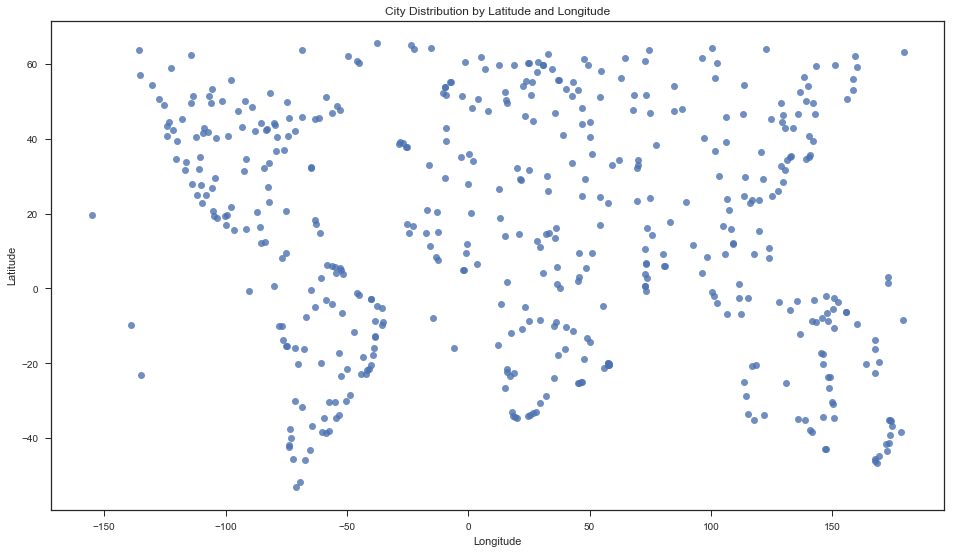

In [8]:
# This is a simple plot of latitude and longitude: it confirms that the sample is sufficiently random across
# the "map" of the world that it shows.
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Longitude", y="Latitude", data=cities, fit_reg=False).set_title('City Distribution by Latitude and Longitude')
# plt.savefig('city_map.png')
plt.show()

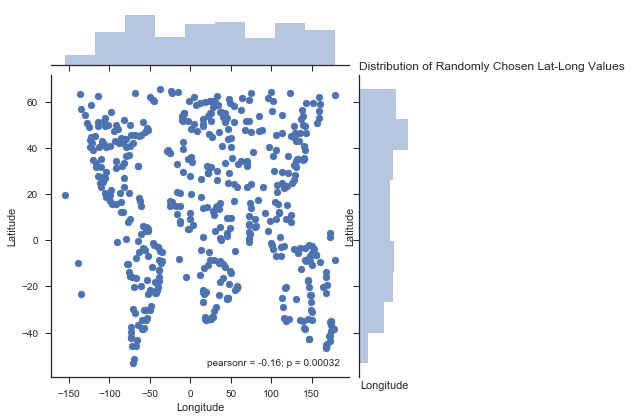

In [9]:
# Similarly, this jointplot confirms decent distribution of points across populated latitudes and longitudes.

sns.set_style('ticks')
p = sns.jointplot(x="Longitude", y="Latitude", data=cities)
plt.title('Distribution of Randomly Chosen Lat-Long Values', loc = 'left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.savefig('city_distribution.png')
plt.show()

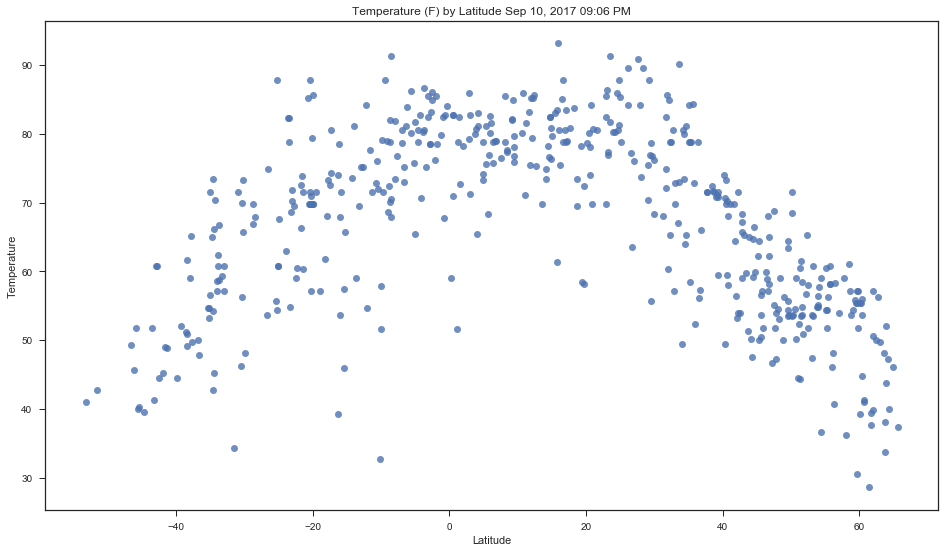

In [10]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Latitude", y="Temperature", data=cities, fit_reg=False).set_title('Temperature (F) by Latitude %s' % analysistimename)
# plt.savefig('temp_by_lat.png')
plt.show()

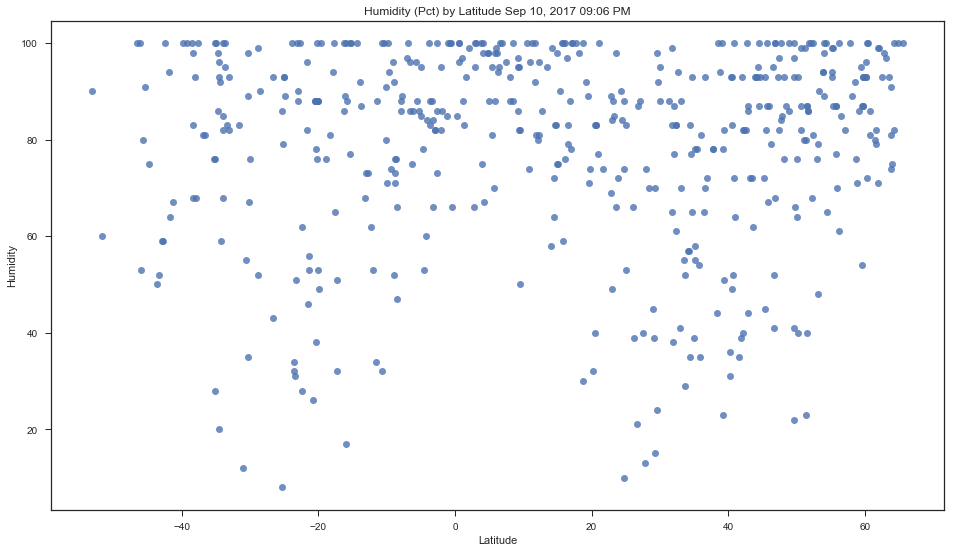

In [13]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Latitude", y="Humidity", data=cities, fit_reg=False).set_title("Humidity (Pct) by Latitude %s" % analysistimename)
# plt.savefig('humidity_by_lat.png')
plt.show()

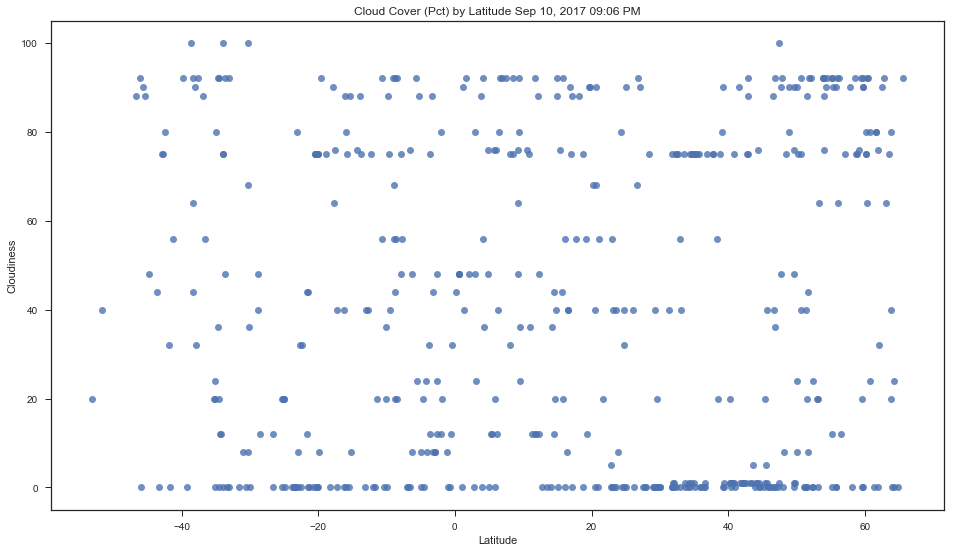

In [15]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Latitude", y="Cloudiness", data=cities, fit_reg=False).set_title("Cloud Cover (Pct) by Latitude %s" % analysistimename)
# plt.savefig('cloud_cover_by_lat.png')
plt.show()

## Conclusions

1. Temperature varies with latitude: this one is obvious but temperature increases as we move from the poles to the equator. High temperatures also skew northwards because at this moment, the northern hemisphere is currently in summer. Also, the hottest temperatures are found around the tropics (+-23 deg latitude).
2. Humidity increases as we move towards the equator: the distribution of humidity shows only high humidity (>60 degrees Fahrenheit) between about -10 and 15 degrees latitude. Nonetheless, most points have humidity over 60%.
3. Cloud cover is fairly evenly distributed by latitude. While areas with zero cloud cover are concentrated in northern latitudes (probably due to the summer conditions there), cloud cover % seems to vary little between north and south.
